# GAN으로 새로운 패션아이템 생성하기
*GAN을 이용하여 새로운 패션 아이템을 만들어봅니다*

이 프로젝트는 최윤제님의 파이토치 튜토리얼 사용 허락을 받아 참고했습니다.

* [yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial) - MIT License

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

EPOCHS 과 BATCH_SIZE 등 학습에 필요한 하이퍼 파라미터 들을 설정해 줍니다.

In [2]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


학습에 필요한 데이터셋을 로딩합니다. 

In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

생성자는 64차원의 랜덤한 텐서를 입력받아 이에 행렬곱(Linear)과 활성화 함수(ReLU, Tanh) 연산을 실행합니다. 생성자의 결과값은 784차원, 즉 Fashion MNIST 속의 이미지와 같은 차원의 텐서입니다.

In [4]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

판별자는 784차원의 텐서를 입력받습니다. 판별자 역시 입력된 데이터에 행렬곱과 활성화 함수를 실행시키지만, 생성자와 달리 판별자의 결과값은 입력받은 텐서가 진짜인지 구분하는 예측값입니다.

In [5]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

생성자와 판별자 학습에 쓰일 오차 함수와 최적화 알고리즘도 정의해 줍니다.

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

모델 학습에 필요한 준비는 끝났습니다. 그럼 본격적으로 GAN을 학습시키는 loop을 만들어 보겠습니다. 

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.0353, g_loss: 4.5795, D(x): 0.99, D(G(z)): 0.02
Epoch [1/500], d_loss: 0.0207, g_loss: 4.8400, D(x): 0.99, D(G(z)): 0.01
Epoch [2/500], d_loss: 0.0208, g_loss: 6.7210, D(x): 0.99, D(G(z)): 0.01
Epoch [3/500], d_loss: 0.0562, g_loss: 5.7327, D(x): 0.99, D(G(z)): 0.04
Epoch [4/500], d_loss: 0.1537, g_loss: 7.3955, D(x): 0.96, D(G(z)): 0.01
Epoch [5/500], d_loss: 0.2890, g_loss: 5.9182, D(x): 0.93, D(G(z)): 0.04
Epoch [6/500], d_loss: 0.2335, g_loss: 5.8002, D(x): 0.93, D(G(z)): 0.03
Epoch [7/500], d_loss: 0.1111, g_loss: 5.1781, D(x): 0.99, D(G(z)): 0.07
Epoch [8/500], d_loss: 0.3939, g_loss: 6.0438, D(x): 0.89, D(G(z)): 0.01
Epoch [9/500], d_loss: 0.1982, g_loss: 4.1193, D(x): 0.96, D(G(z)): 0.09
Epoch [10/500], d_loss: 0.3053, g_loss: 5.0000, D(x): 0.93, D(G(z)): 0.09
Epoch [11/500], d_loss: 0.3597, g_loss: 3.8982, D(x): 0.87, D(G(z)): 0.05
Epoch [12/500], d_loss: 0.3082, g_loss: 4.2954, D(x): 0.93, D(G(z)): 0.10
Epoch [13/500], d_loss: 0.2371, g_loss: 5.3084, 

Epoch [111/500], d_loss: 0.7124, g_loss: 2.2414, D(x): 0.75, D(G(z)): 0.22
Epoch [112/500], d_loss: 0.9356, g_loss: 1.7013, D(x): 0.69, D(G(z)): 0.24
Epoch [113/500], d_loss: 0.8027, g_loss: 1.7171, D(x): 0.72, D(G(z)): 0.27
Epoch [114/500], d_loss: 0.8141, g_loss: 1.6392, D(x): 0.74, D(G(z)): 0.28
Epoch [115/500], d_loss: 0.8254, g_loss: 1.6652, D(x): 0.71, D(G(z)): 0.22
Epoch [116/500], d_loss: 0.8622, g_loss: 1.6949, D(x): 0.74, D(G(z)): 0.32
Epoch [117/500], d_loss: 0.9677, g_loss: 2.0703, D(x): 0.69, D(G(z)): 0.28
Epoch [118/500], d_loss: 1.1266, g_loss: 1.9132, D(x): 0.61, D(G(z)): 0.17
Epoch [119/500], d_loss: 0.9547, g_loss: 1.2488, D(x): 0.83, D(G(z)): 0.43
Epoch [120/500], d_loss: 0.8658, g_loss: 1.3977, D(x): 0.79, D(G(z)): 0.35
Epoch [121/500], d_loss: 0.8857, g_loss: 1.5309, D(x): 0.71, D(G(z)): 0.29
Epoch [122/500], d_loss: 0.6393, g_loss: 1.9779, D(x): 0.84, D(G(z)): 0.28
Epoch [123/500], d_loss: 0.7713, g_loss: 1.7291, D(x): 0.70, D(G(z)): 0.20
Epoch [124/500], d_loss: 

Epoch [221/500], d_loss: 1.1263, g_loss: 1.3004, D(x): 0.66, D(G(z)): 0.39
Epoch [222/500], d_loss: 1.1092, g_loss: 1.2381, D(x): 0.64, D(G(z)): 0.37
Epoch [223/500], d_loss: 0.8626, g_loss: 1.3710, D(x): 0.72, D(G(z)): 0.32
Epoch [224/500], d_loss: 0.9928, g_loss: 1.3832, D(x): 0.73, D(G(z)): 0.38
Epoch [225/500], d_loss: 1.0119, g_loss: 1.5089, D(x): 0.64, D(G(z)): 0.31
Epoch [226/500], d_loss: 1.0609, g_loss: 1.6157, D(x): 0.67, D(G(z)): 0.32
Epoch [227/500], d_loss: 0.8652, g_loss: 1.4949, D(x): 0.72, D(G(z)): 0.33
Epoch [228/500], d_loss: 1.0230, g_loss: 1.5590, D(x): 0.65, D(G(z)): 0.32
Epoch [229/500], d_loss: 0.9471, g_loss: 1.4736, D(x): 0.71, D(G(z)): 0.34
Epoch [230/500], d_loss: 1.2314, g_loss: 1.3161, D(x): 0.58, D(G(z)): 0.35
Epoch [231/500], d_loss: 0.8634, g_loss: 1.4010, D(x): 0.74, D(G(z)): 0.32
Epoch [232/500], d_loss: 1.0469, g_loss: 1.2846, D(x): 0.67, D(G(z)): 0.36
Epoch [233/500], d_loss: 1.0392, g_loss: 1.4090, D(x): 0.63, D(G(z)): 0.31
Epoch [234/500], d_loss: 

Epoch [331/500], d_loss: 0.9890, g_loss: 1.1310, D(x): 0.71, D(G(z)): 0.40
Epoch [332/500], d_loss: 0.7404, g_loss: 1.7732, D(x): 0.70, D(G(z)): 0.23
Epoch [333/500], d_loss: 1.0005, g_loss: 1.3604, D(x): 0.69, D(G(z)): 0.36
Epoch [334/500], d_loss: 1.4437, g_loss: 1.0994, D(x): 0.53, D(G(z)): 0.40
Epoch [335/500], d_loss: 0.8868, g_loss: 1.3829, D(x): 0.73, D(G(z)): 0.35
Epoch [336/500], d_loss: 0.8635, g_loss: 1.4343, D(x): 0.70, D(G(z)): 0.31
Epoch [337/500], d_loss: 1.1889, g_loss: 1.3717, D(x): 0.56, D(G(z)): 0.30
Epoch [338/500], d_loss: 1.1880, g_loss: 1.2512, D(x): 0.64, D(G(z)): 0.40
Epoch [339/500], d_loss: 1.1491, g_loss: 1.3130, D(x): 0.60, D(G(z)): 0.33
Epoch [340/500], d_loss: 0.9684, g_loss: 1.3494, D(x): 0.67, D(G(z)): 0.33
Epoch [341/500], d_loss: 0.7114, g_loss: 1.9377, D(x): 0.75, D(G(z)): 0.28
Epoch [342/500], d_loss: 1.1577, g_loss: 1.5487, D(x): 0.59, D(G(z)): 0.33
Epoch [343/500], d_loss: 1.2421, g_loss: 1.2815, D(x): 0.59, D(G(z)): 0.36
Epoch [344/500], d_loss: 

Epoch [441/500], d_loss: 0.9420, g_loss: 1.2448, D(x): 0.69, D(G(z)): 0.36
Epoch [442/500], d_loss: 0.8875, g_loss: 1.5646, D(x): 0.71, D(G(z)): 0.32
Epoch [443/500], d_loss: 0.9400, g_loss: 1.2521, D(x): 0.70, D(G(z)): 0.33
Epoch [444/500], d_loss: 1.1099, g_loss: 1.2434, D(x): 0.68, D(G(z)): 0.37
Epoch [445/500], d_loss: 1.2045, g_loss: 1.3568, D(x): 0.59, D(G(z)): 0.34
Epoch [446/500], d_loss: 0.8978, g_loss: 1.3511, D(x): 0.69, D(G(z)): 0.32
Epoch [447/500], d_loss: 0.7988, g_loss: 1.5881, D(x): 0.72, D(G(z)): 0.28
Epoch [448/500], d_loss: 0.8578, g_loss: 1.3999, D(x): 0.76, D(G(z)): 0.34
Epoch [449/500], d_loss: 0.9504, g_loss: 1.3742, D(x): 0.72, D(G(z)): 0.35
Epoch [450/500], d_loss: 1.2930, g_loss: 1.1855, D(x): 0.61, D(G(z)): 0.40
Epoch [451/500], d_loss: 1.2956, g_loss: 1.1676, D(x): 0.64, D(G(z)): 0.45
Epoch [452/500], d_loss: 0.9261, g_loss: 1.4396, D(x): 0.67, D(G(z)): 0.31
Epoch [453/500], d_loss: 1.2335, g_loss: 1.1853, D(x): 0.62, D(G(z)): 0.40
Epoch [454/500], d_loss: 

학습이 끝난 생성자의 결과물을 한번 확인해 보겠습니다.

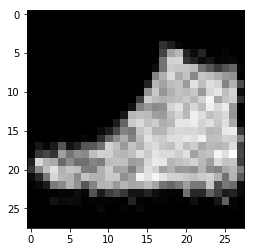

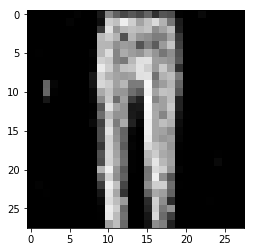

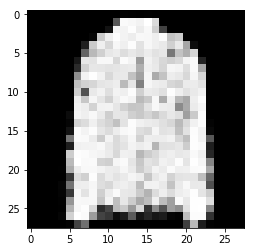

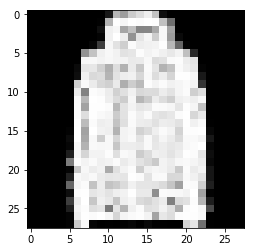

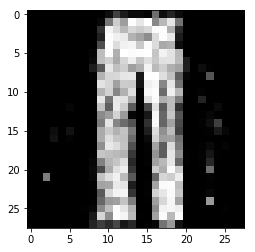

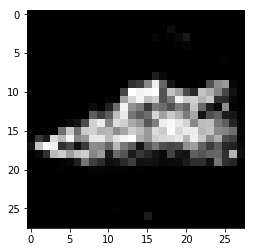

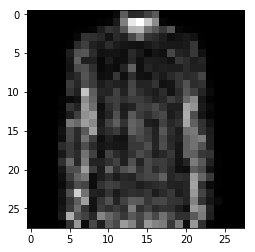

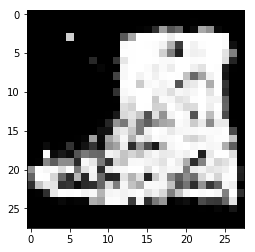

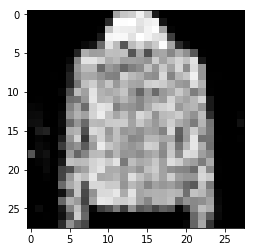

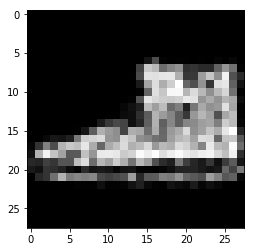

In [8]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()